<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/Guarreteo/ELM_Iquito(00_03).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Inicio




## 1.1 - Leyenda



Var | Significado
--- | ---
city | Abreviación de la ciudad
week_start_date | Fecha de inicio de la semana

NOAA's GHCN (medidas diarias)

Var | Significado
--- | ---
station_max_temp_c | Temp max
station_min_temp_c | Temp min
station_avg_temp_c | Temp media
station_precip_mm | Precipitacion total
station_diur_temp_rng_c | Rango de temperatura diurna


PERSIANN satellite

Var | Significado
--- | ---
precipitation_amt_mm | Precipitación total

NOAA's NCEP Climate Forecast System 

Var | Significado
--- | ---
reanalysis_sat_precip_amt_mm | Precipitación total
reanalysis_dew_point_temp_k | Temp. media del punto de rocio
reanalysis_air_temp_k | Temp. media aire
reanalysis_relative_humidity_percent | Humedadd relativa media
reanalysis_specific_humidity_g_per_kg | Humedad especifica media
reanalysis_precip_amt_kg_per_m2 | Precipitacion total (kg/m2)
reanalysis_max_air_temp_k | Temp. max del aire
reanalysis_min_air_temp_k | Temp. min del aire
reanalysis_avg_temp_k | Temp. media del aire
reanalysis_tdtr_k | Rango de temperaturas diurno


Satellite vegetation, NDVI - NOAA's CDR 

Var | Significado
--- | ---
ndvi_se | Pixel southeast of city centroid
ndvi_sw | Pixel southwest of city centroid
ndvi_ne | Pixel northeast of city centroid
ndvi_nw | Pixel northwest of city centroid

## 1.2 - Librerías y carga de datos



In [ ]:
# data load and manipulation
from google.colab import files
import io
# dataframes library
import pandas as pd
# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
# basic operations
import numpy as np
from numpy import corrcoef, transpose, arange
import itertools


Hay **dos datatsets**, uno con los datos meteorológicos y otro con los casos!

In [ ]:
raw_dataset_features = pd.read_csv('/content/dengue_features_train.csv',index_col=[0,1,2])
raw_dataset_labels = pd.read_csv('/content/dengue_labels_train.csv',index_col=[0,1,2])
raw_dataset_features

week_start_date  ...  station_precip_mm
city year weekofyear                  ...                   
sj   1990 18              1990-04-30  ...               16.0
          19              1990-05-07  ...                8.6
          20              1990-05-14  ...               41.4
          21              1990-05-21  ...                4.0
          22              1990-05-28  ...                5.8
...                              ...  ...                ...
iq   2010 21              2010-05-28  ...               27.0
          22              2010-06-04  ...               36.6
          23              2010-06-11  ...                7.4
          24              2010-06-18  ...               16.0
          25              2010-06-25  ...               20.4

[1456 rows x 21 columns]

In [ ]:
raw_dataset_labels.head()

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6

## 1.3 - Filtro

Filtramos los datos por año (2000 - 2003) de la ciudad de Iquito


In [ ]:
#lo tuve que cambiar porque necesitaba estar indexado, y no he sido capaz de hacerlo todo en el mismo paso 
dataset_features = raw_dataset_features.loc['iq']
dataset_features = dataset_features.loc[2000:2003]

dataset_labels = raw_dataset_labels.loc["iq"]
dataset_labels = dataset_labels.loc[2000:2003]
dataset_features



week_start_date  ...  station_precip_mm
year weekofyear                  ...                   
2000 26              2000-07-01  ...                3.0
     27              2000-07-08  ...               55.6
     28              2000-07-15  ...               38.1
     29              2000-07-22  ...               30.0
     30              2000-07-29  ...                4.0
...                         ...  ...                ...
2003 48              2003-11-26  ...               26.2
     49              2003-12-03  ...              138.0
     50              2003-12-10  ...               47.4
     51              2003-12-17  ...               66.8
     52              2003-12-24  ...              185.7

[182 rows x 21 columns]

In [ ]:
dataset_correlacion = dataset_features.copy(deep=True)
del(dataset_correlacion['week_start_date'])

dataset_correlacion.head()

ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
year weekofyear                      ...                                       
2000 26          0.192886  0.132257  ...                20.7                3.0
     27          0.216833  0.276100  ...                20.8               55.6
     28          0.176757  0.173129  ...                20.7               38.1
     29          0.227729  0.145429  ...                14.7               30.0
     30          0.328643  0.322129  ...                19.1                4.0

[5 rows x 20 columns]

Eliminamos las variables de ciudad, ya que en todos los casos va a ser Iquitos, y la fecha en la que comienza la semana.

# Reducción de la dimensionalidad

Las razones por las que nos interesa reducir la dimensionalidad son varias:


*   Para identificar y eliminar **variables irrelevantes**.
*   Porque **no siempre el mejor modelo es el que más variables** tiene en cuenta.
*   Porque se **mejora el rendimiento** computacional.
*   Porque el **KISS (Keep It Simple, Stupid!)** está de moda.






### Correlacion entre variables

Quitamos Iquitos

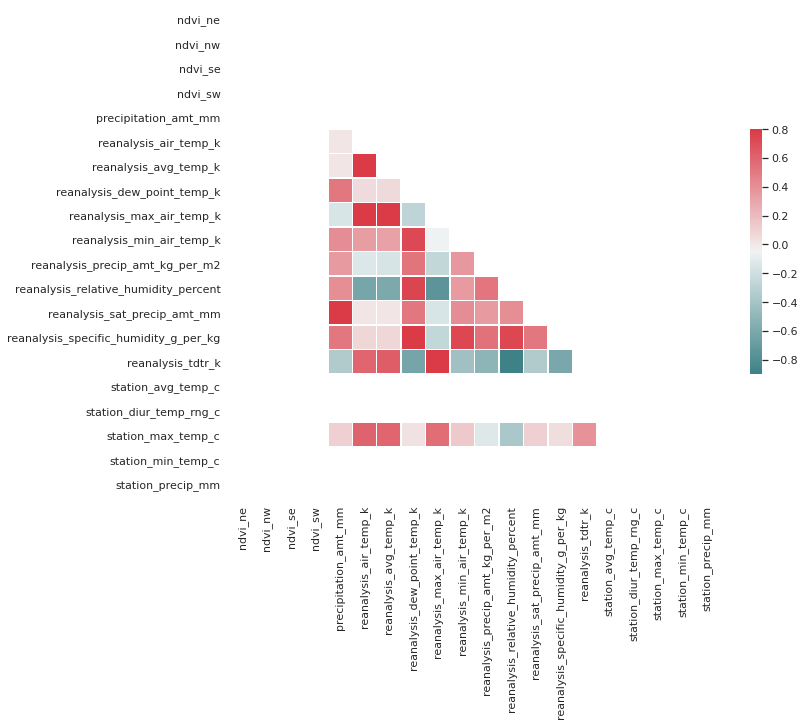

In [ ]:
dataset_correlacion = transpose(dataset_correlacion)
names = dataset_correlacion.index.values

R = corrcoef(dataset_correlacion)
sns.set(style="white")

mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(200, 10, as_cmap= True)

sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Aunque no tenemos variables que tengan una correlación directa, si que se pueden considerar fuertes:



*   Reanalysis_precip_amt_kg_per_m2 con ndvi_se
*   ndvi_sw con Precipitation_amt_mm  y reanalysis_avg_temp_k
*   Reanalysis_air_temp_k con reanalysis_max_air_temp_k y reanalysis_relative_humidity_percent



### Principal Component Analisis (PCA)
(aqui poner otra conclusion bonita)


# Movidas de Manu
### (Pendiente de Revisión grupal)

In [ ]:

print(dataset_features.shape)
print(dataset_labels.shape)


(182, 21)
(182, 1)


Quitamos un pcoo de redundancia, nos damos cuenta que el mismo dato está incluido varias veces como la t**emperatura y las precipitaciones** porque tienen como **origen distintas fuentes**, sería interesante estudiar dichos valores.

Otros en cambio como **week_start_date** puede ir fuera porque se pueden inferir de **weekofyear** y por el momento sólo vamos a trabajar con Iquitos.

In [ ]:
dataset_features = raw_dataset_features.loc['iq']
dataset_features = dataset_features.loc[2000:2003]

dataset_labels = raw_dataset_labels.loc["iq"]
dataset_labels = dataset_labels.loc[2000:2003]


dataset_features.drop("week_start_date", axis = 1, inplace = True)

In [ ]:
dataset_features.head()


ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
year weekofyear                      ...                                       
2000 26          0.192886  0.132257  ...                20.7                3.0
     27          0.216833  0.276100  ...                20.8               55.6
     28          0.176757  0.173129  ...                20.7               38.1
     29          0.227729  0.145429  ...                14.7               30.0
     30          0.328643  0.322129  ...                19.1                4.0

[5 rows x 20 columns]

In [ ]:
dataset_labels.head()

total_cases
year weekofyear             
2000 26                    0
     27                    0
     28                    0
     29                    0
     30                    0

Vemos si hay campos vacíos (SPOILER sí), destacamos que en estos caso podemos deducir más o menos que los campos vacíos son debidos a problemas de medición de las estaciones y el satélite

In [ ]:
pd.isnull(dataset_features).any()

ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                       False
station_min_temp_c                        True
station_precip_mm                         True
dtype: bool

De momento las vamos a auto-completar de manera estandar.

In [ ]:
dataset_features.fillna(method='ffill', inplace=True)
pd.isnull(dataset_features).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

**Nos dan una pista...**

Our target variable, **total_cases** is a non-negative integer, which means we're looking to make some count predictions. Standard regression techniques for this type of prediction include

1.   Poisson regression
2.   Negative binomial regression

Which techniqe will perform better depends on many things, but the choice between Poisson regression and negative binomial regression is pretty straightforward. **Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal**. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better. Why? It isn't magic. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models. In fact, from this perspective, the Poisson distribution is but a special case of the negative binomial distribution.
Fuente: https://www.drivendata.co/blog/dengue-benchmark/

Vamos a ver cuál se adapta mejor a nuestros datos, viendo si hay algún campo vacío primero:

In [ ]:
pd.isnull(dataset_labels).any()

total_cases    False
dtype: bool

In [ ]:
print('Iquitos 2000-2003 \n')
print('mean: ', dataset_labels.mean()[0])
print('var :', dataset_labels.var()[0])

Iquitos 2000-2003 

mean:  4.593406593406593
var : 53.73432092769104


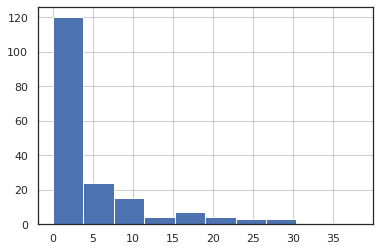

In [ ]:
dataset_labels["total_cases"].hist()

El modelo de Poisson es apropiado cuando la variable dependiente es un conteo, como por ejemplo, el número de llamadas que llegan a una central telefónica, que dependen de otras variables como, por ejemplo el día de la semana o la hora del día. Los sucesos tienen que ser independientes.

Al aplicar este tipo de modelos a datos reales, en algunos casos, se dan fenómenos tales como:

*   **Sobredispersión**: Una peculiaridad de la distribución de Poisson es que su media 
es igual a su varianza. Sin embargo, en ciertos conjuntos de datos se observa una varianza superior a la esperada. El fenómeno se conoce como sobredispersión e indica que el modelo no es adecuado. Un motivo frecuente es la omisión de alguna variable relevante. En algunos casos se aconseja recurrir a la distribución binomial negativa.**Probaremos**

*   **Exceso de ceros**: Otro fenómeno que aparece en la práctica es el del exceso de ceros. Puede deberse a que existen dos fenómenos estadísticos que se entrecruzan: uno genera ceros; otro, los valores no nulos. Esto ocurre, por ejemplo, al tratar de modelar el número de cigarrillos fumados por cada uno de los integrantes de un grupo de personas: puede que algunos de ellos, simplemente, no sean fumadores.**Tenemos 120 semanas con ceros es posible que podamos tirar por aquí también, puede que el virus vaya por oleadas, estaciones, épocas de reproducción/migración del mosquito y puede que no todas las semanas sean importantes...**

Fuente: https://es.wikipedia.org/wiki/Regresión_de_Poisson

Añadimos los casos totales para realizar la correlación

In [ ]:
dataset_features['total_cases'] = dataset_labels.total_cases
dataset_features.head()

ndvi_ne   ndvi_nw  ...  station_precip_mm  total_cases
year weekofyear                      ...                                
2000 26          0.192886  0.132257  ...                3.0            0
     27          0.216833  0.276100  ...               55.6            0
     28          0.176757  0.173129  ...               38.1            0
     29          0.227729  0.145429  ...               30.0            0
     30          0.328643  0.322129  ...                4.0            0

[5 rows x 21 columns]

Text(0.5, 1.0, 'Iquitos 2000-2003 Variable Correlations')

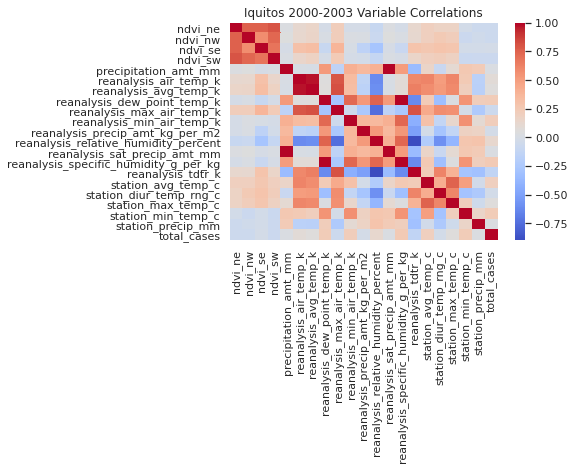

In [ ]:
dataset_correlations = dataset_features.corr()
dataset_corr_heat = sns.heatmap(dataset_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)

plt.title('Iquitos 2000-2003 Variable Correlations')

Estudiar correlaciones

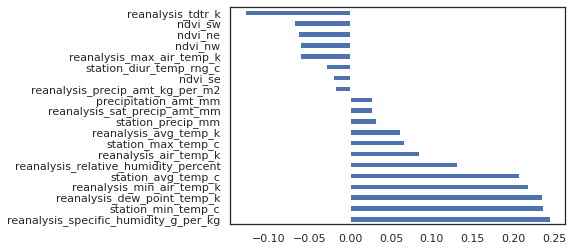

In [ ]:
(dataset_correlations
     .total_cases
     .drop('total_cases')
     .sort_values(ascending=False)
     .plot
     .barh())